# Problem statement: 

To build a multiclass classification model using a custom convolutional neural network in TensorFlow; a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries needed for training a CNN and processing data

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau, TensorBoard

import warnings
warnings.filterwarnings("ignore")



### Importing Skin Cancer Data

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')


##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [ ]:
#root_path = 'gdrive/My Drive/UpGrad/Course_4_ANN/Melanoma_data/'  #change dir to your project folder (old folder)
root_path = 'gdrive/My Drive/UpGrad/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/'  #changing dir to my project folder
#root_path = 'gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/'  #changing dir to my project folder

# Note: You can see multiple pats ere as I had to use different google accounts to train multiple CNNs

Data Summary:

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following 9 classes of diseases:

1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion


Importing following Skin Cancer Data:
- Training image folders
- Testing image folders

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

#data_dir_train = pathlib.Path('gdrive/My Drive/UpGrad/Course_4_ANN/Melanoma_data/Train')
#data_dir_test = pathlib.Path('gdrive/My Drive/UpGrad/Course_4_ANN/Melanoma_data/Test')

#data_dir_train = pathlib.Path('gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
#data_dir_test = pathlib.Path('gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

data_dir_train = pathlib.Path('gdrive/My Drive/UpGrad/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('gdrive/My Drive/UpGrad/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

As can be seen from above cell, out of total 2357 images, we have 2239 images for training and 118 images for tesing the model performance. 

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels = 'inferred',
    label_mode = 'int',
    class_names = None,
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.2, #None,
    subset = "training",
    interpolation = 'bilinear',
    follow_links = False,
    crop_to_aspect_ratio = False,
    #**kwargs
)   ##todo


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels = 'inferred',
    label_mode = 'int',
    class_names = None,
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.2, #None,
    subset = "validation",
    interpolation = 'bilinear',
    follow_links = False,
    crop_to_aspect_ratio = False,
    #**kwargs
) ##todo

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


So we can see that 80% of 2239 of training images will be used of training, which comes to 1792 images and rest 20% i.e. 447 images will be used for validation.

In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print("The 9 classes of skin cancers that the model will be classifying are: \n", class_names)

The 9 classes of skin cancers that the model will be classifying are: 
 ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Let us create a code to visualize one instance of all the nine classes present in the dataset

Found 2239 files belonging to 9 classes.


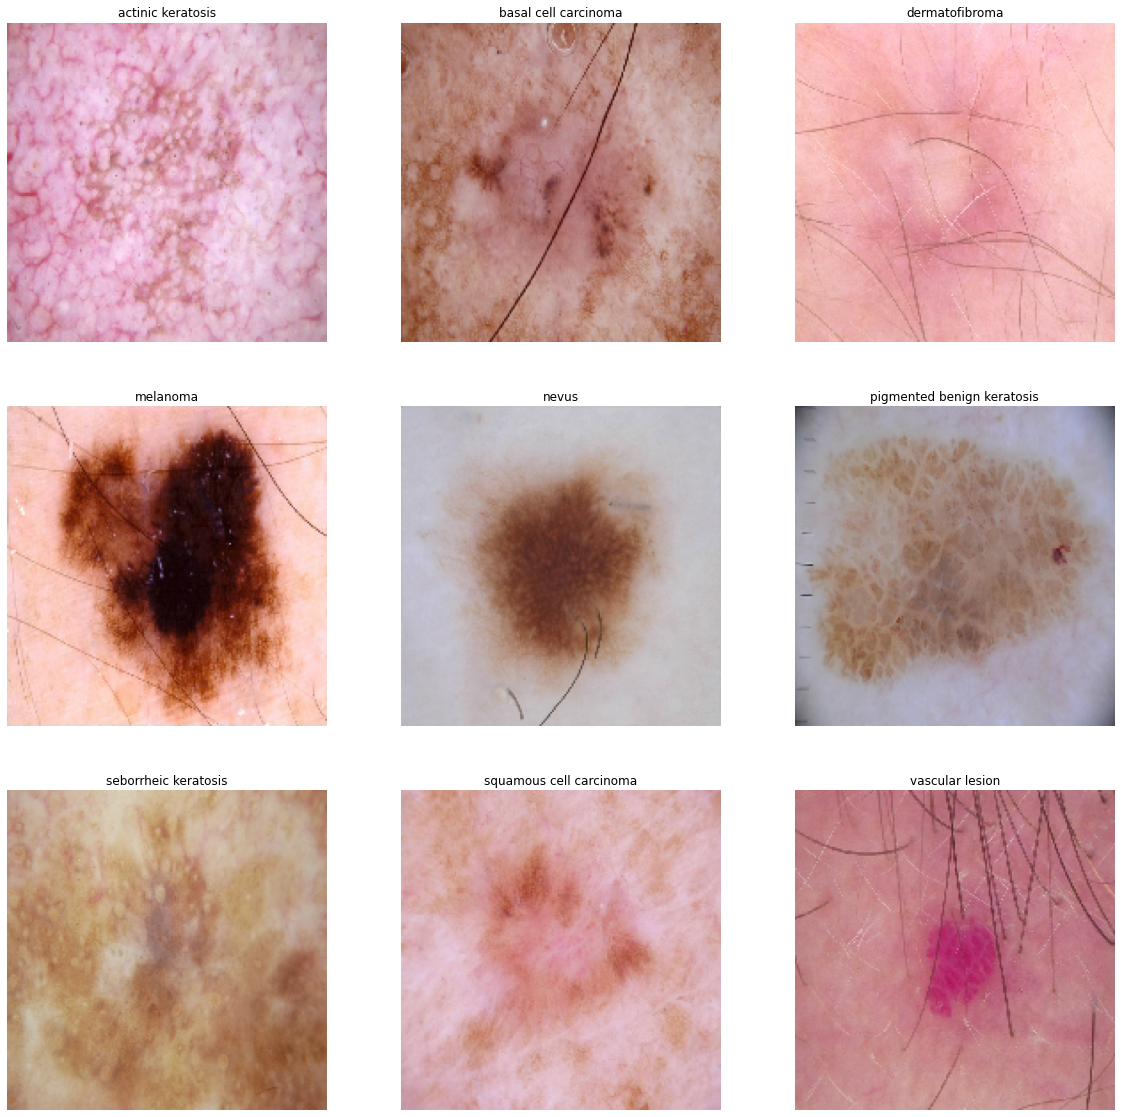

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size = batch_size, image_size = (img_height, img_width),
                                                                    label_mode = 'categorical', seed = 123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize = (20,20))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(load_img(path_list[0],target_size=(img_height, img_width)))
    plt.title(c)
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

## Visualize distribution of classes in the training dataset

Class distribution: Examine the current class distribution in the training dataset 
- Which class has the least number of samples?
- Which classes dominate the data in terms of the proportionate number of samples?


In [ ]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Images'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Images
0,actinic keratosis,114
1,nevus,357
2,basal cell carcinoma,376
3,squamous cell carcinoma,181
4,melanoma,438
5,dermatofibroma,95
6,vascular lesion,139
7,seborrheic keratosis,77
8,pigmented benign keratosis,462


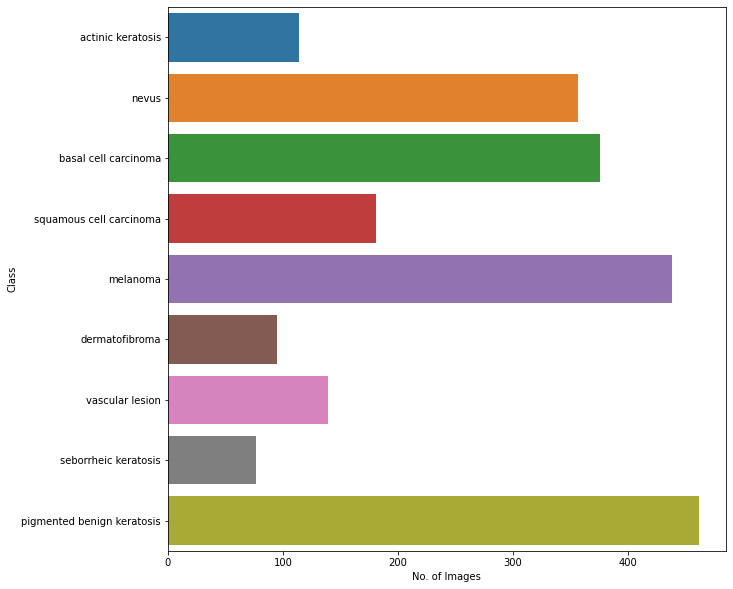

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(x="No. of Images", y="Class", data=df,
            label="Class")

Observations on class distribution:
- pigmented benign keratosis and melanoma have larger number of images, 462 and 438 respectively
- seborrheic keratosis	and dermatofibroma	have least number of images, 77 and 95 respectively 

So there is a clear class imbalance in the data which is not a good quality for training data. However, let us see how the training goes. If the model is biased or overfitted or underfitted, we might have to do something to correct this imbalance. 


Let us start working towards training our first model.


Using following function in the next step:

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) 
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
]

In [ ]:
### Creating first CNN Model

input_shape = (img_height, img_width,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

#Sequential allows you to create models layer-by-layer  
model = Sequential()

#Rescaling Layer
#model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# Using 3x3 filters as they are most commonly used and found to be most efficient

#First Convulation layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

#Second Convulation Layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#Third Convulation Layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#Fourth Convulation Layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#Flatten Layer
model.add(Flatten())

#Dense Layer1
model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))

# Not using dropout layer in this model, as first want to see if the model has an overfitting issues
# will use this in the next model in case needed
#Dropout layer with 25% Fraction of the input units to drop, tis is done to avoid overfitting
#model.add(Dropout(0.25))

#Dense Layer2 with softmax activation function
#Softmax is an activation function that scales numbers/logits into probabilities, using this as we are dealing with a multiclass classification
model.add(layers.Dense(len(class_names),activation='softmax')) ## Number of classes is 9

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_3 (Batc  (None, 176, 176, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 86, 86, 64)      

Compile the model

Choose an appropirate optimiser and loss function for model training

In [ ]:
# model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
model.compile(optimizer = "Adam", 
              loss = "sparse_categorical_crossentropy", 
              metrics = ["accuracy"])

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy & sparse_categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.


In [ ]:
#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.

checkpoint_path="gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/CNN_model1_noDropOut"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

#Reduce learning rate when a metric stops improving.
#Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
#This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=8,
                                  verbose=1,factor=0.2, min_lr=1e-7)

#Stop training when a monitored metric stops improving # not using it now as want to see how the training goes if we go for all epochs
#earlystop = EarlyStopping(monitor = "val_accuracy", patience = 8, mode = "auto", verbose = 1)

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_3 (Batc  (None, 176, 176, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 86, 86, 64)      

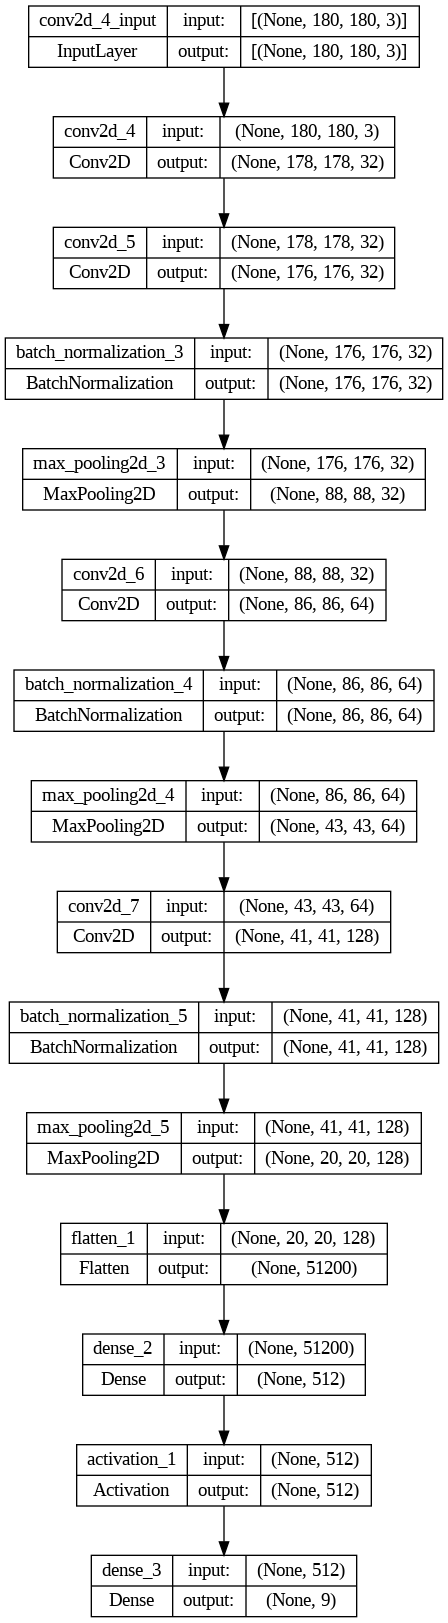

In [ ]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Train the first model

In [ ]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

''' 
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)
'''

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 10.9446 - accuracy: 0.2863
Epoch 1: val_accuracy improved from -inf to 0.18792, saving model to gdrive/My Drive/UpGrad/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/CNN_model1_noDropOut


56/56 [==============================] - 402s 7s/step - loss: 10.9446 - accuracy: 0.2863 - val_loss: 12.9824 - val_accuracy: 0.1879
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 2.6565 - accuracy: 0.3733
Epoch 2: val_accuracy did not improve from 0.18792
56/56 [==============================] - 352s 6s/step - loss: 2.6565 - accuracy: 0.3733 - val_loss: 10.4362 - val_accuracy: 0.0872
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.8131 - accuracy: 0.4520
Epoch 3: val_accuracy improved from 0.18792 to 0.26622, saving model to gdrive/My Drive/UpGrad/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/CNN_model1_noDropOut


56/56 [==============================] - 350s 6s/step - loss: 1.8131 - accuracy: 0.4520 - val_loss: 6.9063 - val_accuracy: 0.2662
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.5595 - accuracy: 0.5190
Epoch 4: val_accuracy did not improve from 0.26622
56/56 [==============================] - 352s 6s/step - loss: 1.5595 - accuracy: 0.5190 - val_loss: 7.6010 - val_accuracy: 0.2192
Epoch 5/20
56/56 [==============================] - ETA: 0s - loss: 1.1926 - accuracy: 0.5804
Epoch 5: val_accuracy improved from 0.26622 to 0.41163, saving model to gdrive/My Drive/UpGrad/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/CNN_model1_noDropOut


56/56 [==============================] - 352s 6s/step - loss: 1.1926 - accuracy: 0.5804 - val_loss: 3.7090 - val_accuracy: 0.4116
Epoch 6/20
56/56 [==============================] - ETA: 0s - loss: 0.9535 - accuracy: 0.6663
Epoch 6: val_accuracy did not improve from 0.41163
56/56 [==============================] - 349s 6s/step - loss: 0.9535 - accuracy: 0.6663 - val_loss: 1.9746 - val_accuracy: 0.3803
Epoch 7/20
56/56 [==============================] - ETA: 0s - loss: 0.7605 - accuracy: 0.7388
Epoch 7: val_accuracy did not improve from 0.41163
56/56 [==============================] - 349s 6s/step - loss: 0.7605 - accuracy: 0.7388 - val_loss: 2.8144 - val_accuracy: 0.3199
Epoch 8/20
56/56 [==============================] - ETA: 0s - loss: 0.6374 - accuracy: 0.7695
Epoch 8: val_accuracy did not improve from 0.41163
56/56 [==============================] - 347s 6s/step - loss: 0.6374 - accuracy: 0.7695 - val_loss: 5.8018 - val_accuracy: 0.3020
Epoch 9/20
56/56 [===========================

56/56 [==============================] - 351s 6s/step - loss: 0.6913 - accuracy: 0.7533 - val_loss: 2.9889 - val_accuracy: 0.4228
Epoch 10/20
56/56 [==============================] - ETA: 0s - loss: 0.4791 - accuracy: 0.8309
Epoch 10: val_accuracy did not improve from 0.42282
56/56 [==============================] - 370s 7s/step - loss: 0.4791 - accuracy: 0.8309 - val_loss: 3.1418 - val_accuracy: 0.3221
Epoch 11/20
56/56 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.8767
Epoch 11: val_accuracy did not improve from 0.42282
56/56 [==============================] - 344s 6s/step - loss: 0.3358 - accuracy: 0.8767 - val_loss: 7.3626 - val_accuracy: 0.2573
Epoch 12/20
56/56 [==============================] - ETA: 0s - loss: 0.2461 - accuracy: 0.9007
Epoch 12: val_accuracy improved from 0.42282 to 0.44295, saving model to gdrive/My Drive/UpGrad/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/CNN_model1_noDropOut


56/56 [==============================] - 346s 6s/step - loss: 0.2461 - accuracy: 0.9007 - val_loss: 2.9559 - val_accuracy: 0.4430
Epoch 13/20
56/56 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9241
Epoch 13: val_accuracy did not improve from 0.44295
56/56 [==============================] - 344s 6s/step - loss: 0.1804 - accuracy: 0.9241 - val_loss: 3.4407 - val_accuracy: 0.4094
Epoch 14/20
56/56 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9291
Epoch 14: val_accuracy improved from 0.44295 to 0.47204, saving model to gdrive/My Drive/UpGrad/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/CNN_model1_noDropOut


56/56 [==============================] - 350s 6s/step - loss: 0.1609 - accuracy: 0.9291 - val_loss: 2.6112 - val_accuracy: 0.4720
Epoch 15/20
56/56 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0.9369
Epoch 15: val_accuracy did not improve from 0.47204
56/56 [==============================] - 344s 6s/step - loss: 0.1647 - accuracy: 0.9369 - val_loss: 2.7243 - val_accuracy: 0.4116
Epoch 16/20
56/56 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9431
Epoch 16: val_accuracy did not improve from 0.47204
56/56 [==============================] - 351s 6s/step - loss: 0.1282 - accuracy: 0.9431 - val_loss: 3.0057 - val_accuracy: 0.4720
Epoch 17/20
56/56 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.9425
Epoch 17: val_accuracy did not improve from 0.47204
56/56 [==============================] - 373s 7s/step - loss: 0.1262 - accuracy: 0.9425 - val_loss: 3.1934 - val_accuracy: 0.4161
Epoch 18/20
56/56 [====================

56/56 [==============================] - 354s 6s/step - loss: 0.1454 - accuracy: 0.9420 - val_loss: 2.8597 - val_accuracy: 0.4899
Epoch 19/20
56/56 [==============================] - ETA: 0s - loss: 0.1625 - accuracy: 0.9280
Epoch 19: val_accuracy did not improve from 0.48993
56/56 [==============================] - 354s 6s/step - loss: 0.1625 - accuracy: 0.9280 - val_loss: 4.1863 - val_accuracy: 0.3602
Epoch 20/20
56/56 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9375
Epoch 20: val_accuracy did not improve from 0.48993
56/56 [==============================] - 349s 6s/step - loss: 0.1435 - accuracy: 0.9375 - val_loss: 6.2721 - val_accuracy: 0.3535


' \nhistory = model.fit(\n  train_ds,\n  validation_data=val_ds,\n  epochs=epochs,\n  callbacks=[checkpoint,earlystop]\n)\n'

In [ ]:
os.listdir(checkpoint_dir)

['Train', 'Test', 'CNN_model1', 'CNN_model1_noDropOut']

In [ ]:
# Save the entire model
#!mkdir -p parul_saved_model
#model.save('parul_saved_model/model1_noDropOut')


## Visualizing training results of CNN Model 1

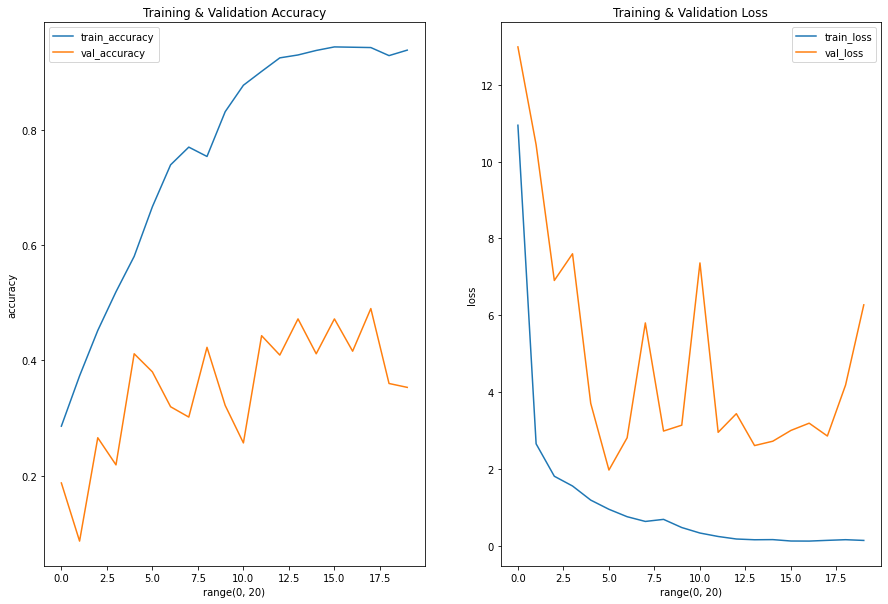

In [ ]:
# Plot the training and validation graphs

#epochs_range = range(earlystop.stopped_epoch+1)

epochs_range = range(epochs)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training & Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training & Validation Loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()


Let us list our findings on the above model fit, see if there is an evidence of model overfit or underfit

## Observations and learnings (First CNN Model, no batch normalization, no dropout, no data augmentation):
- While training accuracy is increasing almost consistently (at first rapidly and then slowly but steadily) from 0.28 to 0.94, validation accuracy is going up in a zig-zag manner but not able to cross 0.47. This clearly indicates that model is an overfit, remembering the training data well but nor performing half that well with unseen data
- The loss graph also narates the same story. For training data, at first it decreses rapidly and then little slowly, from 10.94 to 0.14, which is very impressive. However, validation loss, togh have a decreasing trend, does so in a zig-zag fashion, with minimum loss value at 2.72. 
-in both the metrics, training data performance is good but on validation data, model is not doing a good job - indicating overfitting

### How to improve this model?
- overfitting can be due to imbalance in the data which we had anticipated after class distribution visualization. 
- we can try and augment the training data in order to balance the class distribution

### We need to choose an appropriate data augumentation strategy to manage data distribution imbalance


In [ ]:
# Code for custom generated augmented images
import warnings
warnings.filterwarnings("ignore")

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

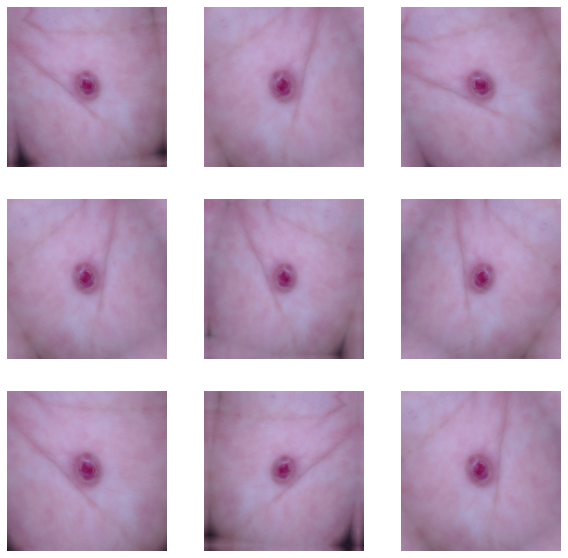

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

import warnings
warnings.filterwarnings("ignore")


plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Todo:
Create the next model which can perform better thhan the first model, using the insights, compile and train the model


In [ ]:
## Using Dropout layer this time as we found overfitting in previous model
# Using a Dropout layer with 20% Fraction of the input units to drop, this is done to avoid overfitting that was observed in the first model

## Creating CNN Model 2 with dropout

import warnings
warnings.filterwarnings("ignore")

model2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names)) 
]) ## Number of classes is 9

"\ninput_shape = (img_height, img_width,3)\nlr = 1e-5\ninit = 'normal'\nactiv = 'relu'\n\nmodel2 = Sequential([\n  data_augmentation,\n  layers.experimental.preprocessing.Rescaling(1./255),\n  layers.Conv2D(16, 3, padding='same', activation='relu'),\n  #BatchNormalization(),\n  layers.MaxPooling2D(),\n  layers.Conv2D(32, 3, padding='same', activation='relu'),\n  #BatchNormalization(),\n  layers.MaxPooling2D(),\n  layers.Conv2D(64, 3, padding='same', activation='relu'),\n  #BatchNormalization(),\n  layers.MaxPooling2D(),\n  #layers.Conv2D(128, 3, padding='same', activation='relu'),\n  #BatchNormalization(),\n  #layers.MaxPooling2D(),\n  layers.Dropout(0.25),\n  layers.Flatten(),\n  layers.Dense(128, activation='relu'),\n  #layers.Dropout(0.25),\n  layers.Dense(len(class_names),activation='softmax')\n\n])\n"

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Compiling the model 2


Choose an appropirate optimiser and loss function for model training

In [ ]:
## Your code goes here
### choosing an appropirate optimiser and loss function
# model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
model2.compile(optimizer = "Adam", 
              loss = "sparse_categorical_crossentropy", 
              metrics = ["accuracy"])

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy & sparse_categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.


In [ ]:
#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.

checkpoint_path2="gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/CNN2_augment_DropOut"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)

checkpoint2 = ModelCheckpoint(checkpoint_path2, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

#Reduce learning rate when a metric stops improving.
#Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
#This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
#learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=8, verbose=1,factor=0.2, min_lr=1e-7)

#Stop training when a monitored metric stops improving # not using it now as want to see how the training goes if we go for all epochs
#earlystop = EarlyStopping(monitor = "val_accuracy", patience = 8, mode = "auto", verbose = 1)

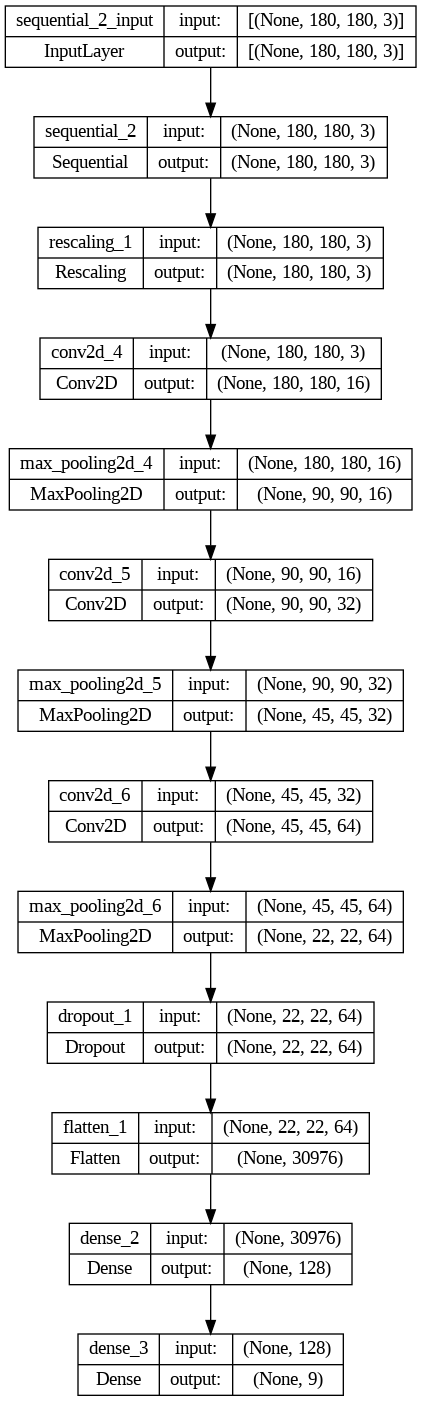

In [ ]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training of model 2

In [ ]:
## train your model for 20 epochs
epochs = 20
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  #callbacks=[checkpoint2]
)


Epoch 1/20


56/56 [==============================] - ETA: 0s - loss: 1.0757 - accuracy: 0.6217
Epoch 1: val_accuracy improved from -inf to 0.55928, saving model to gdrive/My Drive/UpGrad/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/CNN2_augment_DropOut


56/56 [==============================] - 122s 2s/step - loss: 1.0757 - accuracy: 0.6217 - val_loss: 1.3408 - val_accuracy: 0.5593
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.0195 - accuracy: 0.6423
Epoch 2: val_accuracy did not improve from 0.55928
56/56 [==============================] - 103s 2s/step - loss: 1.0195 - accuracy: 0.6423 - val_loss: 1.3351 - val_accuracy: 0.5324
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.0015 - accuracy: 0.6283
Epoch 3: val_accuracy did not improve from 0.55928
56/56 [==============================] - 109s 2s/step - loss: 1.0015 - accuracy: 0.6283 - val_loss: 1.3715 - val_accuracy: 0.5213
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.0013 - accuracy: 0.6362
Epoch 4: val_accuracy did not improve from 0.55928
56/56 [==============================] - 107s 2s/step - loss: 1.0013 - accuracy: 0.6362 - val_loss: 1.4665 - val_accuracy: 0.4922
Epoch 5/20
56/56 [===========================

### Visualizing the results of Model 2

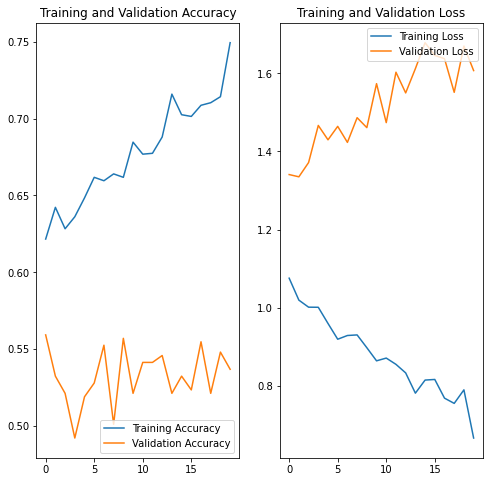

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Findings after the model 2 fit. Let us check if there is some improvement now as compared to the previous model run?


- So in this model, we tried to manage data imbalance and overfitting by adding some images which were generated by rotating, flipping original images.
- while the above performance graph looks a little bizarre, if we observe carefully and compare it with the previous model, it is definitely an improved model. Let us see why it is a better model:
	- It reduced the gap between training accuracy and validation accuracy hence reducing overfitting. In the previous model training and validation accuracy was 93.75% & 35.35% resp. While in this model it is 74.94% & 53.69% resp. A significant improvement in overfitting issue.
	- In the raph, the validation loss is increasing instead of reducing, however it is still quite less compared to first model. Validation loss in previous model was 6.27 v/s now 1.6, a significant reduction in loss.
- However, this cannot be the best model, there is scope for a lot of improvement as accuracy is clearly not that good. Given this can be a question of life-&-death, we need higher accuracy without overfitting. 



We have already seen earlier that distribution of classes is not balanced.
Running the code ere again for reference.

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

So let us investigate distribution little further.


In [ ]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)


2239

In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,gdrive/My Drive/UpGrad/Course_4_ANN/Skin cance...,actinic keratosis
1,gdrive/My Drive/UpGrad/Course_4_ANN/Skin cance...,actinic keratosis
2,gdrive/My Drive/UpGrad/Course_4_ANN/Skin cance...,actinic keratosis
3,gdrive/My Drive/UpGrad/Course_4_ANN/Skin cance...,actinic keratosis
4,gdrive/My Drive/UpGrad/Course_4_ANN/Skin cance...,actinic keratosis
...,...,...
2234,gdrive/My Drive/UpGrad/Course_4_ANN/Skin cance...,pigmented benign keratosis
2235,gdrive/My Drive/UpGrad/Course_4_ANN/Skin cance...,pigmented benign keratosis
2236,gdrive/My Drive/UpGrad/Course_4_ANN/Skin cance...,pigmented benign keratosis
2237,gdrive/My Drive/UpGrad/Course_4_ANN/Skin cance...,pigmented benign keratosis


Class=0, n=114 (5.092%)
Class=4, n=357 (15.945%)
Class=1, n=376 (16.793%)
Class=7, n=181 (8.084%)
Class=3, n=438 (19.562%)
Class=2, n=95 (4.243%)
Class=8, n=139 (6.208%)
Class=6, n=77 (3.439%)
Class=5, n=462 (20.634%)


<BarContainer object of 9 artists>

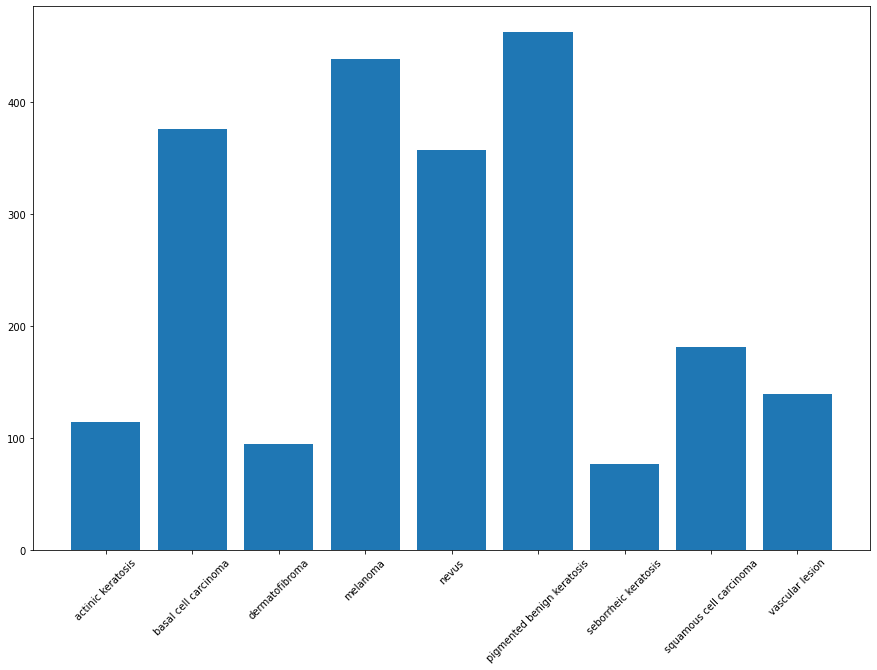

In [ ]:
### Checking the distribution of all the images category wise

from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
plt.bar(class_names,count)


In [ ]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Images'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Images
0,actinic keratosis,114
1,nevus,357
2,basal cell carcinoma,376
3,squamous cell carcinoma,181
4,melanoma,438
5,dermatofibroma,95
6,vascular lesion,139
7,seborrheic keratosis,77
8,pigmented benign keratosis,462


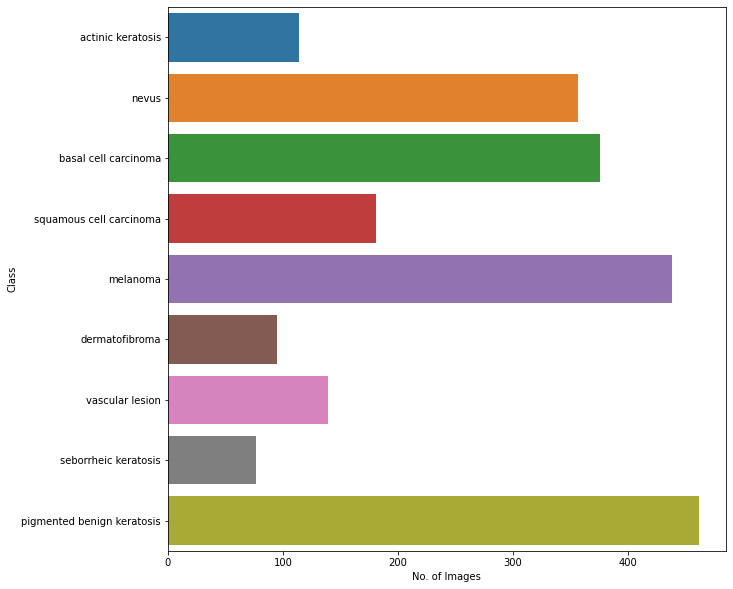

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(x="No. of Images", y="Class", data=df,
            label="Class")

Todo: Write your findings here:
- Which class has the least number of samples?
  - seborrheic keratosis	has the least number of images = 77, wich is 3.439 %
- Which classes dominate the data in terms proportionate number of samples?
  - pigmented benign keratosis and melanoma with 462 images (20.634%) and 438 images (19.562%) resp.


Let us rectify the class imbalance.

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
#code to install Augmentor
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.


In [ ]:
#path_to_training_dataset="gdrive/My Drive/UpGrad/Course_4_ANN/Melanoma_data/Train"
path_to_training_dataset="/content/gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation = 10, max_right_rotation = 10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1EB655BFD0>: 100%|██████████| 500/500 [00:34<00:00, 14.36 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1EB6513C10>: 100%|██████████| 500/500 [00:27<00:00, 17.88 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1EB65AABE0>: 100%|██████████| 500/500 [00:26<00:00, 19.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1EB652D880>: 100%|██████████| 500/500 [01:47<00:00,  4.67 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F1EB650B610>: 100%|██████████| 500/500 [02:03<00:00,  4.05 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1F6899CF70>: 100%|██████████| 500/500 [00:27<00:00, 18.44 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1EB65025E0>: 100%|██████████| 500/500 [00:57<00:00,  8.71 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1EB65B0F70>: 100%|██████████| 500/500 [00:29<00:00, 16.95 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1EB661CA30>: 100%|██████████| 500/500 [00:26<00:00, 18.54 Samples/s]


Augmentor has generated the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
#Count total number of image generated by Augmentor.
from glob import glob

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets check te class istribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(len(path_list_new))

4500


In [ ]:
print(path_list_new[1]) # printing one sample just to cross check

gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028854.jpg_024dbdaf-257d-4481-9e1d-8a266288e55f.jpg


In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(len(lesion_list_new))

4500


In [ ]:
print(lesion_list_new[0]) # printing a sample
print(lesion_list_new[500]) # printing a sample
print(lesion_list_new[1000]) # printing a sample


actinic keratosis
pigmented benign keratosis
dermatofibroma


In [ ]:
### Creating the new dataframe with path list and lesion list
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
### Concatenating the new dataframe with columns Path and label
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(len(path_list))

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])


df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

2239


In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have 500 aumented images that got added in each class. The class imbalance is managed to a certain extent as no class has sparse data. One can add more images if we want and check if that improves training an further.

#### Let us train the model 3 on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
#data_dir_train="path to directory with training data + data created using augmentor"
#data_dir_train = pathlib.Path('gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_train = pathlib.Path('gdrive/My Drive/UpGrad/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Train')


train_ds3 = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
#data_dir_test = pathlib.Path('gdrive/My Drive/UpGrad/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

val_ds3 = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
class_names = train_ds3.class_names
print("The 9 classes of skin cancers that the model will be classifying are: \n", class_names)

The 9 classes of skin cancers that the model will be classifying are: 
 ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds3 = train_ds3.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds3 = val_ds3.cache().prefetch(buffer_size=AUTOTUNE)


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## code for creating Model 3
#CNN Model Architecture

input_shape = (img_height, img_width,3)
lr = 1e-5
init = 'normal'
activ = 'relu'


#Sequential allows you to create models layer-by-layer  
model3 = Sequential()

model3.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

#Second Convulation Layer
model3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2, 2)))

#Third Convulation Layer
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2, 2)))

#Fourth Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model3.add(BatchNormalization())
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model3.add(layers.Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model3.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model3.add(layers.Dense(len(class_names),activation='softmax'))

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 176, 176, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        1

#### Compile the model (Choose optimizer and loss function appropriately)

In [ ]:
## compiling code goes here
### choosing an appropirate optimiser and loss function
model3.compile(optimizer = "Adam", 
              loss = "sparse_categorical_crossentropy", 
              metrics = ["accuracy"])

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy & sparse_categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.


In [ ]:
#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.

checkpoint_path3="gdrive/My Drive/UpGrad/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/CNN3_augmentor_DropOut"
checkpoint_dir3 = os.path.dirname(checkpoint_path3)

checkpoint3 = ModelCheckpoint(checkpoint_path3, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

#Reduce learning rate when a metric stops improving.
#Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
#This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
#learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=8, verbose=1,factor=0.2, min_lr=1e-7)

#Stop training when a monitored metric stops improving # not using it now as want to see how the training goes if we go for all epochs
#earlystop = EarlyStopping(monitor = "val_accuracy", patience = 8, mode = "auto", verbose = 1)

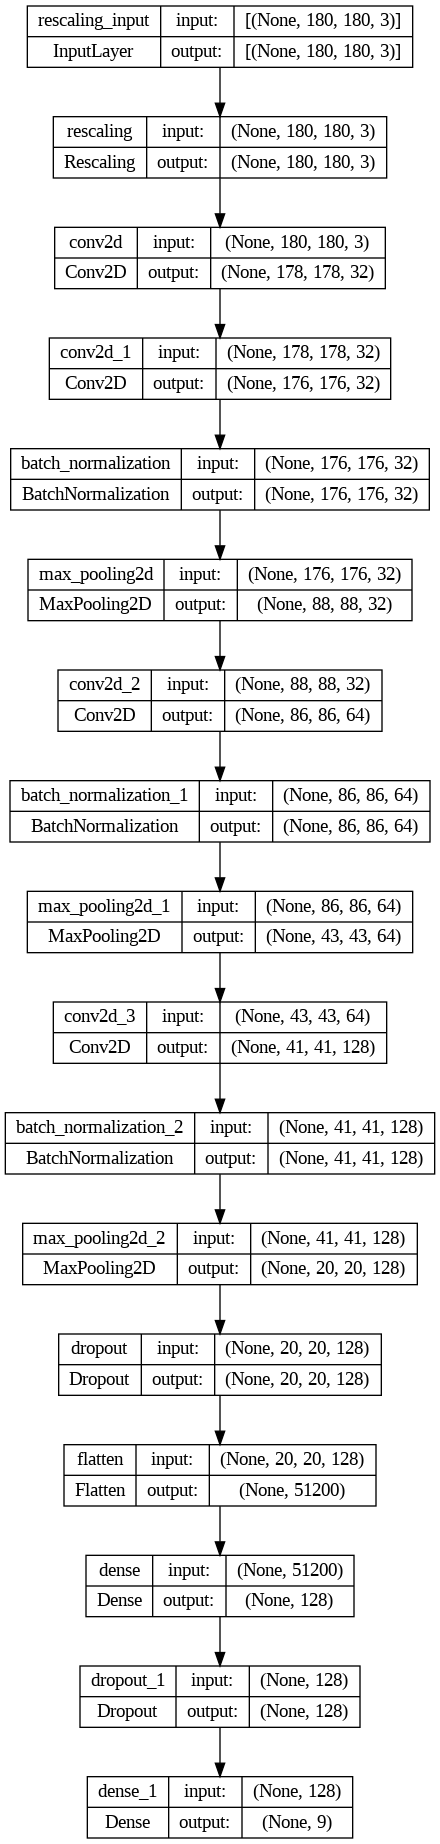

In [ ]:
# vizualizing the model 3
from tensorflow.keras.utils import plot_model
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Let us train your model 3 with 30 epochs

In [ ]:
epochs = 30 ## using 30 epochs.
history3 = model3.fit(
  train_ds3,
  validation_data=val_ds3,
  epochs=epochs,
  callbacks=[checkpoint3]
)

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 3.8385 - accuracy: 0.2174
Epoch 1: val_accuracy improved from -inf to 0.10839, saving model to gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/CNN3_augmentor_DropOut


169/169 [==============================] - 1048s 6s/step - loss: 3.8385 - accuracy: 0.2174 - val_loss: 41.6771 - val_accuracy: 0.1084
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 2.0497 - accuracy: 0.2784
Epoch 2: val_accuracy improved from 0.10839 to 0.14477, saving model to gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/CNN3_augmentor_DropOut


169/169 [==============================] - 978s 6s/step - loss: 2.0497 - accuracy: 0.2784 - val_loss: 19.9746 - val_accuracy: 0.1448
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.8092 - accuracy: 0.3266
Epoch 3: val_accuracy improved from 0.14477 to 0.30512, saving model to gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/CNN3_augmentor_DropOut


169/169 [==============================] - 979s 6s/step - loss: 1.8092 - accuracy: 0.3266 - val_loss: 1.8470 - val_accuracy: 0.3051
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 1.6986 - accuracy: 0.3472
Epoch 4: val_accuracy did not improve from 0.30512
169/169 [==============================] - 986s 6s/step - loss: 1.6986 - accuracy: 0.3472 - val_loss: 11.1927 - val_accuracy: 0.1084
Epoch 5/30
169/169 [==============================] - ETA: 0s - loss: 1.5620 - accuracy: 0.3778
Epoch 5: val_accuracy did not improve from 0.30512
169/169 [==============================] - 973s 6s/step - loss: 1.5620 - accuracy: 0.3778 - val_loss: 8.6449 - val_accuracy: 0.1715
Epoch 6/30
169/169 [==============================] - ETA: 0s - loss: 1.4358 - accuracy: 0.4184
Epoch 6: val_accuracy did not improve from 0.30512
169/169 [==============================] - 978s 6s/step - loss: 1.4358 - accuracy: 0.4184 - val_loss: 4.4301 - val_accuracy: 0.2509
Epoch 7/30
169/169 [==========

169/169 [==============================] - 1007s 6s/step - loss: 1.2445 - accuracy: 0.4996 - val_loss: 1.1967 - val_accuracy: 0.5071
Epoch 9/30
169/169 [==============================] - ETA: 0s - loss: 1.1618 - accuracy: 0.5317
Epoch 9: val_accuracy improved from 0.50705 to 0.55828, saving model to gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/CNN3_augmentor_DropOut


169/169 [==============================] - 970s 6s/step - loss: 1.1618 - accuracy: 0.5317 - val_loss: 1.2455 - val_accuracy: 0.5583
Epoch 10/30
169/169 [==============================] - ETA: 0s - loss: 1.1205 - accuracy: 0.5558
Epoch 10: val_accuracy did not improve from 0.55828
169/169 [==============================] - 938s 6s/step - loss: 1.1205 - accuracy: 0.5558 - val_loss: 1.7518 - val_accuracy: 0.4217
Epoch 11/30
169/169 [==============================] - ETA: 0s - loss: 1.0678 - accuracy: 0.5744
Epoch 11: val_accuracy did not improve from 0.55828
169/169 [==============================] - 962s 6s/step - loss: 1.0678 - accuracy: 0.5744 - val_loss: 1.2739 - val_accuracy: 0.5004
Epoch 12/30
169/169 [==============================] - ETA: 0s - loss: 0.9487 - accuracy: 0.6194
Epoch 12: val_accuracy did not improve from 0.55828
169/169 [==============================] - 941s 6s/step - loss: 0.9487 - accuracy: 0.6194 - val_loss: 1.4871 - val_accuracy: 0.5122
Epoch 13/30
169/169 [====

169/169 [==============================] - 975s 6s/step - loss: 0.7354 - accuracy: 0.6877 - val_loss: 0.9955 - val_accuracy: 0.6488
Epoch 17/30
169/169 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.7190
Epoch 17: val_accuracy did not improve from 0.64885
169/169 [==============================] - 974s 6s/step - loss: 0.7054 - accuracy: 0.7190 - val_loss: 1.3144 - val_accuracy: 0.5226
Epoch 18/30
169/169 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.7246
Epoch 18: val_accuracy did not improve from 0.64885
169/169 [==============================] - 971s 6s/step - loss: 0.6780 - accuracy: 0.7246 - val_loss: 1.2751 - val_accuracy: 0.6199
Epoch 19/30
169/169 [==============================] - ETA: 0s - loss: 0.6345 - accuracy: 0.7404
Epoch 19: val_accuracy did not improve from 0.64885
169/169 [==============================] - 962s 6s/step - loss: 0.6345 - accuracy: 0.7404 - val_loss: 1.6558 - val_accuracy: 0.6065
Epoch 20/30
169/169 [====

169/169 [==============================] - 961s 6s/step - loss: 0.6080 - accuracy: 0.7515 - val_loss: 0.7036 - val_accuracy: 0.7684
Epoch 22/30
169/169 [==============================] - ETA: 0s - loss: 0.5573 - accuracy: 0.7693
Epoch 22: val_accuracy did not improve from 0.76837
169/169 [==============================] - 964s 6s/step - loss: 0.5573 - accuracy: 0.7693 - val_loss: 1.5636 - val_accuracy: 0.5353
Epoch 23/30
169/169 [==============================] - ETA: 0s - loss: 0.5396 - accuracy: 0.7832
Epoch 23: val_accuracy did not improve from 0.76837
169/169 [==============================] - 963s 6s/step - loss: 0.5396 - accuracy: 0.7832 - val_loss: 10.0548 - val_accuracy: 0.3066
Epoch 24/30
169/169 [==============================] - ETA: 0s - loss: 0.5465 - accuracy: 0.7817
Epoch 24: val_accuracy did not improve from 0.76837
169/169 [==============================] - 972s 6s/step - loss: 0.5465 - accuracy: 0.7817 - val_loss: 0.9341 - val_accuracy: 0.6837
Epoch 25/30
169/169 [===

#### Visualize the model 3 results

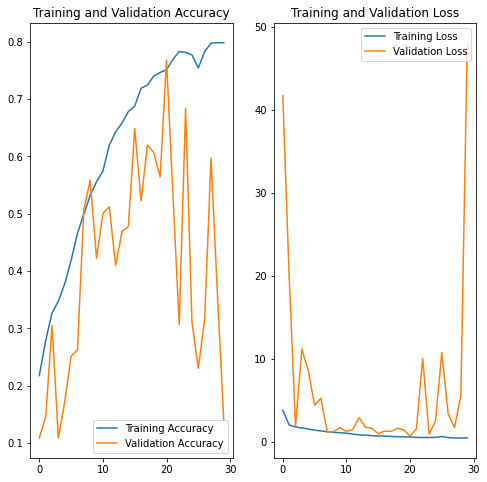

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Let us analyze the results here. Did we get rid of overfitting? Did class rebalance help?

There is a lot to learn and infer from this training performance:
- Training accuracy was increasing almost consistently (except one dip towards the end)
- Validation accuracy, though a little up-&-down, was increasing epoch 21, after which it was unstable and trend was more downward
- interestingly, epoch 21 had training and validation accuracy quite close to each other at 75% & 77%. At this point model almost overcame the overfitting
- However final training accuracy of 79.86%, though an improvement from the previous model (model2) is still not acceptable. Moreover, final validation accurac is too low (14%) again pointing at overfitting

So what do we do now? Ow to improve this model?
- low accuracy indicates that we are missing out on some important features. Not using a dropout laer after convolution layer may help in retaining all features
- but to overcome overfitting we need dropout layer at least between dense layers

So let us give it one more try in order to get better trained model.



In [ ]:
# Create new model 3b
#CNN Model Architecture
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds3 = train_ds3.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds3 = val_ds3.cache().prefetch(buffer_size=AUTOTUNE)

input_shape = (img_height, img_width,3)

#Sequential allows you to create models layer-by-layer  
model3b = Sequential()

model3b.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model3b.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model3b.add(MaxPool2D())

#Second Convulation Layer
model3b.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
#model3b.add(BatchNormalization())
model3b.add(MaxPool2D())

#Third Convulation Layer
model3b.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model3b.add(BatchNormalization())
model3b.add(MaxPool2D())

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model3b.add(layers.Flatten())

#Dense Layer
model3b.add(layers.Dense(512,activation='relu'))
#Dropout layer with 50% Fraction of the input units to drop.
model3b.add(layers.Dropout(0.5))

#Dense Layer
#model3b.add(layers.Dense(512,activation='relu'))

#Dropout layer with 35% Fraction of the input units to drop.
#model3b.add(layers.Dropout(0.35))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model3b.add(layers.Dense(len(class_names),activation='softmax'))

model3b.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

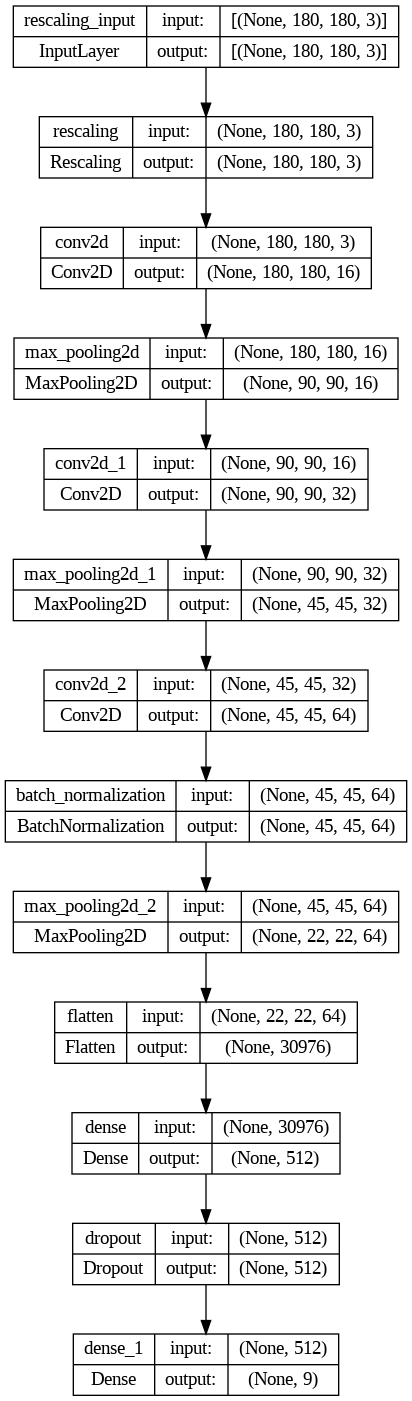

In [ ]:
# Compile model 3b
model3b.compile(optimizer = "Adam", 
              loss = "sparse_categorical_crossentropy", 
              metrics = ["accuracy"])

# vizualizing the model 3b
from tensorflow.keras.utils import plot_model
plot_model(model3b, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
#Stop training when a monitored metric stops improving # not using it now as want to see how the training goes if we go for all epochs
#earlystop = EarlyStopping(monitor = "val_accuracy", patience = 5, mode = "auto", verbose = 1)

## Trainin Model 3b using 30 epochs
epochs = 30

history3b = model3b.fit(
  train_ds3,
  validation_data=val_ds3,
  epochs= epochs,
)

Epoch 1/30
169/169 [==============================] - 614s 721ms/step - loss: 2.0707 - accuracy: 0.3438 - val_loss: 2.1060 - val_accuracy: 0.1952
Epoch 2/30
169/169 [==============================] - 4s 25ms/step - loss: 1.5291 - accuracy: 0.4342 - val_loss: 1.8937 - val_accuracy: 0.2947
Epoch 3/30
169/169 [==============================] - 4s 25ms/step - loss: 1.3553 - accuracy: 0.4948 - val_loss: 4.9128 - val_accuracy: 0.2346
Epoch 4/30
169/169 [==============================] - 4s 26ms/step - loss: 1.2809 - accuracy: 0.5338 - val_loss: 1.3444 - val_accuracy: 0.4959
Epoch 5/30
169/169 [==============================] - 4s 26ms/step - loss: 1.1371 - accuracy: 0.5874 - val_loss: 2.8268 - val_accuracy: 0.3422
Epoch 6/30
169/169 [==============================] - 4s 25ms/step - loss: 0.9964 - accuracy: 0.6430 - val_loss: 2.6524 - val_accuracy: 0.3920
Epoch 7/30
169/169 [==============================] - 4s 26ms/step - loss: 0.8446 - accuracy: 0.7014 - val_loss: 1.8485 - val_accuracy: 0.4

In [ ]:
# Save the weights
model3b.save_weights('gdrive/My Drive/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration//checkpoints/model3b')


In [ ]:
# Create a new model instance
#model3bb = create_model()


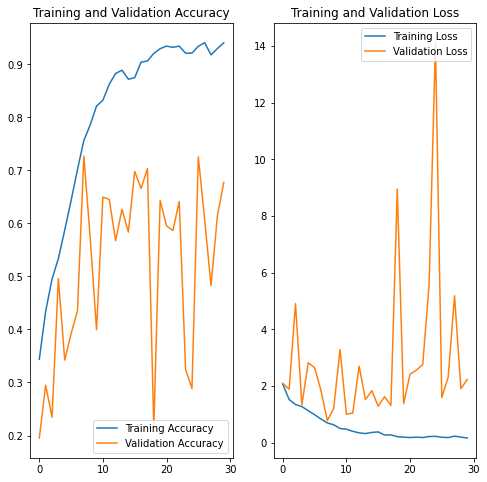

In [ ]:
# Visualize model 3b performance
acc = history3b.history['accuracy']
val_acc = history3b.history['val_accuracy']

loss = history3b.history['loss']
val_loss = history3b.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Final training accuracy: 0.9405 & val_accuracy: 0.6771 

Training loss: 0.1732  & val loss: 2.2363

The gap between both accuracy is less but let us experiment and check if we can do better.

In [ ]:
# Create model 3c
#CNN Model Architecture
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds3 = train_ds3.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds3 = val_ds3.cache().prefetch(buffer_size=AUTOTUNE)

input_shape = (img_height, img_width,3)

#Sequential allows you to create models layer-by-layer  
model3c = Sequential()

model3c.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model3c.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model3c.add(MaxPool2D())

#Second Convulation Layer
model3c.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
#model3b.add(BatchNormalization())
model3c.add(MaxPool2D())

#Third Convulation Layer
model3c.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model3c.add(BatchNormalization())
model3c.add(MaxPool2D())
model3c.add(layers.Dropout(0.2))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model3c.add(layers.Flatten())

#Dense Layer
model3c.add(layers.Dense(128,activation='relu'))
#Dropout layer with 50% Fraction of the input units to drop.
model3c.add(layers.Dropout(0.2))

#Dense Layer
#model3b.add(layers.Dense(512,activation='relu'))

#Dropout layer with 35% Fraction of the input units to drop.
#model3b.add(layers.Dropout(0.35))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model3c.add(layers.Dense(len(class_names),activation='softmax'))

model3c.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

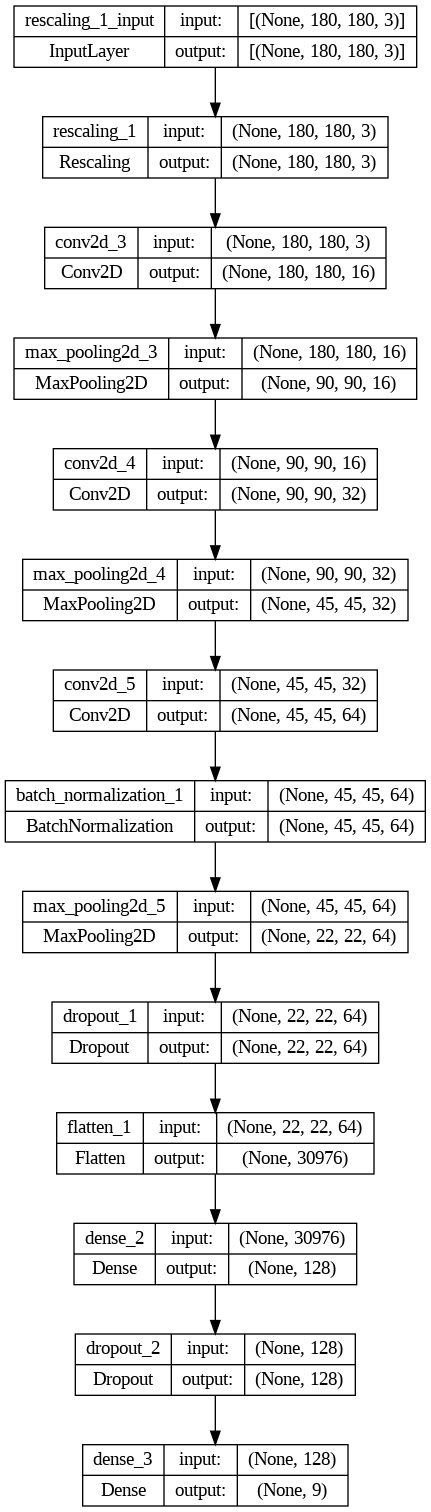

In [ ]:
# Compile model 3c
model3c.compile(optimizer = "Adam", 
              loss = "sparse_categorical_crossentropy", 
              metrics = ["accuracy"])

# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model3c, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
## train model 3c using 30 epochs
epochs = 30

history3c = model3b.fit(
  train_ds3,
  validation_data=val_ds3,
  epochs= epochs,
)

Epoch 1/30
169/169 [==============================] - 4s 25ms/step - loss: 0.1798 - accuracy: 0.9366 - val_loss: 6.8508 - val_accuracy: 0.4892
Epoch 2/30
169/169 [==============================] - 5s 27ms/step - loss: 0.1860 - accuracy: 0.9362 - val_loss: 3.2342 - val_accuracy: 0.5501
Epoch 3/30
169/169 [==============================] - 4s 25ms/step - loss: 0.1627 - accuracy: 0.9447 - val_loss: 5.0977 - val_accuracy: 0.5264
Epoch 4/30
169/169 [==============================] - 4s 25ms/step - loss: 0.1658 - accuracy: 0.9427 - val_loss: 1.4956 - val_accuracy: 0.7394
Epoch 5/30
169/169 [==============================] - 5s 27ms/step - loss: 0.1430 - accuracy: 0.9492 - val_loss: 1.0836 - val_accuracy: 0.7884
Epoch 6/30
169/169 [==============================] - 4s 25ms/step - loss: 0.1637 - accuracy: 0.9449 - val_loss: 4.0538 - val_accuracy: 0.4595
Epoch 7/30
169/169 [==============================] - 4s 25ms/step - loss: 0.2249 - accuracy: 0.9254 - val_loss: 3.6292 - val_accuracy: 0.4878

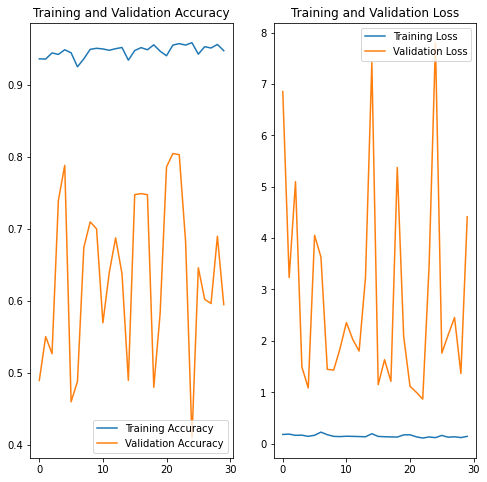

In [ ]:
# Visualizing model 3c performance
acc = history3c.history['accuracy']
val_acc = history3c.history['val_accuracy']

loss = history3c.history['loss']
val_loss = history3c.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Final training accuracy: 0.9479 & val_accuracy: 0.5947 

Training loss: 0.1426  & val loss: 4.4158

The gap between both accuracy is less but previous model did better in that respect. Let us experiment and check if we can do better one last time.

In [ ]:
# Create new model 3d
#CNN Model Architecture
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds3 = train_ds3.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds3 = val_ds3.cache().prefetch(buffer_size=AUTOTUNE)

input_shape = (img_height, img_width,3)

#Sequential allows you to create models layer-by-layer  
model3d = Sequential()

model3d.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

model3d.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model3d.add(MaxPool2D())

model3d.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model3d.add(MaxPool2D())

model3d.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model3d.add(MaxPool2D())

model3d.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model3d.add(MaxPool2D())

model3d.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model3d.add(MaxPool2D())

model3d.add(layers.Dropout(0.2))


#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model3d.add(layers.Flatten())

#Dense Layer
model3d.add(layers.Dense(64,activation='relu'))


#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model3d.add(layers.Dense(len(class_names),activation='softmax'))

model3d.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

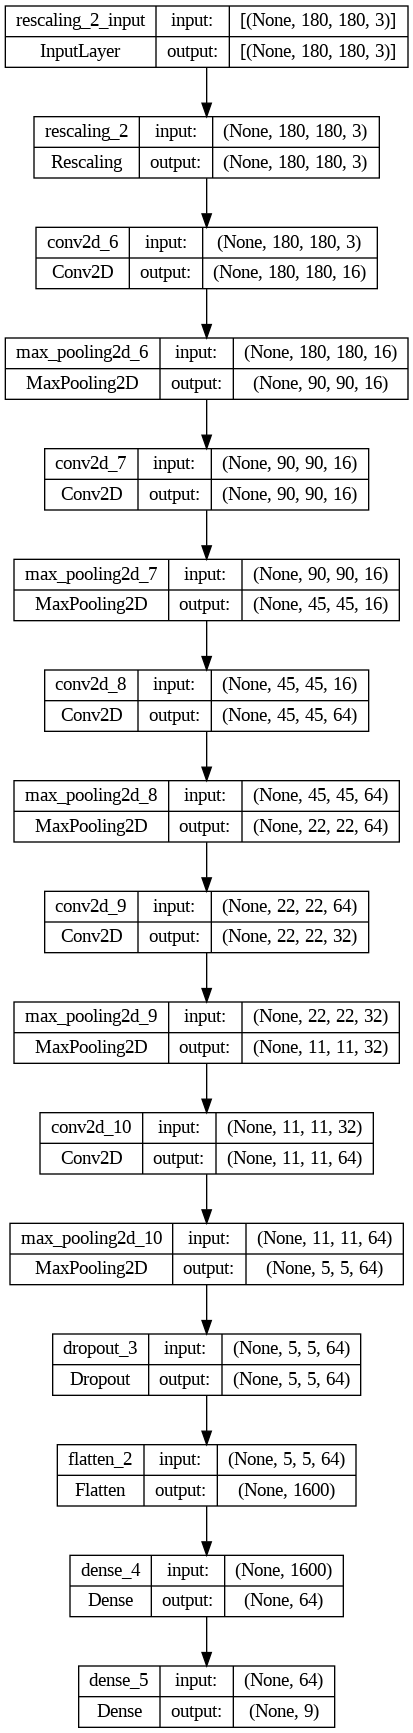

In [ ]:
# Compile new model 3d
model3d.compile(optimizer = "Adam", 
              loss = "sparse_categorical_crossentropy", 
              metrics = ["accuracy"])

# vizualizing the model 3d
from tensorflow.keras.utils import plot_model
plot_model(model3d, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
## train model 3d using 30 epochs
epochs = 30

history3d = model3d.fit(
  train_ds3,
  validation_data=val_ds3,
  epochs= epochs,
)

Epoch 1/30
169/169 [==============================] - 7s 29ms/step - loss: 1.9493 - accuracy: 0.2485 - val_loss: 1.7212 - val_accuracy: 0.3348
Epoch 2/30
169/169 [==============================] - 4s 24ms/step - loss: 1.5908 - accuracy: 0.3948 - val_loss: 1.5035 - val_accuracy: 0.3994
Epoch 3/30
169/169 [==============================] - 4s 24ms/step - loss: 1.4515 - accuracy: 0.4425 - val_loss: 1.4961 - val_accuracy: 0.4284
Epoch 4/30
169/169 [==============================] - 4s 24ms/step - loss: 1.3796 - accuracy: 0.4668 - val_loss: 1.3335 - val_accuracy: 0.4736
Epoch 5/30
169/169 [==============================] - 4s 24ms/step - loss: 1.2542 - accuracy: 0.5111 - val_loss: 1.2422 - val_accuracy: 0.5174
Epoch 6/30
169/169 [==============================] - 4s 24ms/step - loss: 1.1523 - accuracy: 0.5545 - val_loss: 1.1282 - val_accuracy: 0.5568
Epoch 7/30
169/169 [==============================] - 4s 26ms/step - loss: 1.0739 - accuracy: 0.5931 - val_loss: 1.0338 - val_accuracy: 0.6199

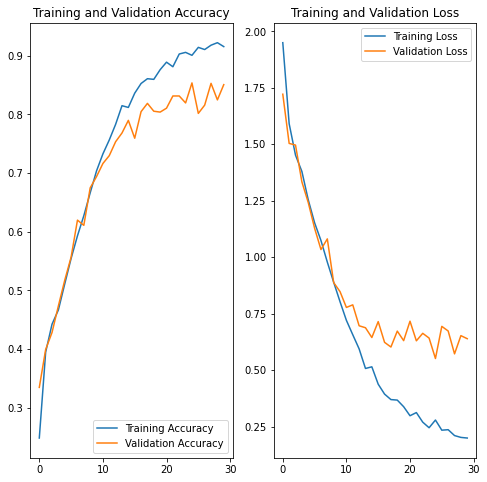

In [ ]:
# Visualizing model 3d performance
acc = history3d.history['accuracy']
val_acc = history3d.history['val_accuracy']

loss = history3d.history['loss']
val_loss = history3d.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Final training accuracy: 0.9156 & val_accuracy: 0.8508 

Training loss: 0.1997  & val loss: 0.6392

The gap between both accuracy is significantly reduced.

In terms of overcoming overfitting, this model is the best so far.

In [ ]:
# Save the weights
model3d.save_weights('gdrive/My Drive/UpGrad/Course_4_ANN/Skin cancer ISIC The International Skin Imaging Collaboration/checkpoints/CNN_model3d')

In [13]:
# Lets look and compare all the models based on the final accuracy 

# list of diff CNN trained
CNN_trained = ['1', '2', '3', '3b', '3c', '3d']

# list of training accuracy
train_acc = [93.75, 74.94, 79.86, 94.05, 94.79, 91.56 ]

# list of training accuracy
val_acc = [35.35, 53.69, 14.03, 67.71, 59.47, 85.08]

# remarks on CNN architecture
remarks = ['No_dropOut+No_DataAug+No_BatchNorm', 'with_dropOut+custom_DataAug+No_BatchNorm', 'with_dropOut+DataAug+BatchNorm', 'with_dropOut+DataAug+BatchNorm', 'with_dropOut+DataAug+No_BatchNorm', 'with_dropOut+DataAug+No_BatchNorm']

# Calling DataFrame constructor after zipping
# both lists, with columns specified
df = pd.DataFrame(list(zip(CNN_trained, train_acc, val_acc, remarks )),columns =['CNN', '% Training Accuracy', '% Val Accuracy', 'Remarks'])

print(df)


  CNN  % Training Accuracy  % Val Accuracy  \
0   1                93.75           35.35   
1   2                74.94           53.69   
2   3                79.86           14.03   
3  3b                94.05           67.71   
4  3c                94.79           59.47   
5  3d                91.56           85.08   

                                    Remarks  
0        No_dropOut+No_DataAug+No_BatchNorm  
1  with_dropOut+custom_DataAug+No_BatchNorm  
2            with_dropOut+DataAug+BatchNorm  
3            with_dropOut+DataAug+BatchNorm  
4         with_dropOut+DataAug+No_BatchNorm  
5         with_dropOut+DataAug+No_BatchNorm  


#Performance Evaluation and Conclusions:

- From the above table, we can conclude that out of six CNN thhat we trained, CNN Model 3d is the best with validation accuracy closest to the training accuracy indicating absence of overfitting. This model is trained without batch normalization.

- The next best is CNN Model 3b that was trained with batch normalization. This model has better training accuracy than Model 3d, but lower validation accuracy hinting a little overfitting

- So drop out and data augmentation is useful in overcoming overfitting

- Also we can see that relativel higher number of convolution layers is helping in improving accuracy. This is because important features and patterns are identified better
